## Decision Trees

In [18]:
class TreeNode():
    def print( self, depth = 0 ):
        raise NotImplementedError()            
    def predict( self, x ):
        raise NotImplementedError()
        
class LeafNode( TreeNode ):
    def __init__( self, output_class, confidence ):
        self.output_class = output_class
        self.confidence = confidence

    def print( self, depth = 0 ):
        print( "  " * depth, "Leaf Node", self.output_class, self.confidence )
    
    def predict( self, x ):
        return self.output_class, self.confidence

class InnerNode( TreeNode ):
    def __init__( self, feature, split_value, left_child, right_child ):
        self.feature = feature
        self.split_value = split_value
        self.left_child = left_child
        self.right_child = right_child

    def print( self, depth = 0 ):
        print( "  " * depth, "Inner Node (", feature_names[self.feature], "<", self.split_value, ")" )
        self.left_child.print( depth + 1 )
        self.right_child.print( depth + 1 )
    
    def predict( self, x ):
        if x[ self.feature ] <= self.split_value:
            return self.left_child.predict( x )
        return self.right_child.predict( x )

## Aufbauen eines Decision Trees

In [19]:
from pyexpat import features
from re import split
import numpy

def count_occurance_of_class(data_points, searched_class): #gibt die Anzahl der Vorkommen einer Klasse in einem Datensatz zurück
    count = 0
    for _, class_label in data_points:
        if class_label == searched_class:
            count += 1
    return count

def get_unqiue_classes(data_points): #gibt eine Liste mit den einzigartigen Klassen zurück
    classes = set()
    for _, class_label in data_points:
        classes.add(class_label)
    return list(classes)

def gini_index( data_points ): #berechnet den Gini-Index
    total_count = len(data_points)
    gini = 1 - sum( [ ( count_occurance_of_class(data_points, c) / total_count )**2 for c in get_unqiue_classes(data_points) ] )
    return gini
    

def split_data(data_points, feature_ind, split_value): #teilt die Daten in zwei Teile auf, basierend auf einem Grenzwert(split-value) eines Features
    left = []
    right = []
    for x, _ in data_points:
        if x[feature_ind] <= split_value:
            left.append((x, _))
        else:
            right.append((x, _))
    return left, right

def suggest_split_values( data_points, feature ): #gibt den Median und den Mittelwert der Werte eines Features zurück
    values_of_feature = []
    for x,_ in data_points:
        values_of_feature.append( x[feature] )

    return (numpy.median(values_of_feature), numpy.mean(values_of_feature))


#wählt den besten Split aus, basierend auf dem Gini-Index. 
#Es wird der Split mit dem niedrigsten Gini-Index gewählt (also der Split, der die Klassen am besten trennt)
def select_best_split(data_points):
    splits = []
    features = range(len(data_points[0][0]))
    for feature in features:
        split_values = suggest_split_values(data_points, feature)
        for value in split_values:
            left_data, right_data = split_data(data_points, feature, value)
            if len(left_data) == 0 or len(right_data) == 0:
                continue
            left_gini = gini_index(left_data)
            right_gini = gini_index(right_data)
            total_gini = left_gini + right_gini
            splits.append((feature, value, total_gini))
    splits = sorted(splits, key=lambda x: x[2])
    try:
        feature, split_value, _ = splits[0]
    except:
        print("Error: No split found")
    return (feature, split_value)

# Function to check if all points (ignoring labels) have the same value
def all_points_same_ignore_labels(data):
    """
    Returns:
    bool: True if all points are the same, False otherwise.
    """
    points = [tuple(point) for point, _ in data]
    # Return True if the set of points has length 1 or 0, implying all elements are identical or the list is empty
    return len(set(points)) <= 1

def can_stop_recursion(data_points): #überprüft, ob die Rekursion gestoppt werden kann, weil die Datenpunkte homogen sind oder die Anzahl der Datenpunkte zu gering ist
    if len(get_unqiue_classes(data_points)) == 1: #nur eine Klasse vorhanden
        return True
    elif len(data_points) <= 5: #nur 5 oder weniger Datenpunkte vorhanden
        return True
    elif all_points_same_ignore_labels(data_points): #Features sind identisch
        return True
    else: 
        return False

def decision_for_subset(data_points): #gibt die Klasse zurück, die am häufigsten vorkommt und die Konfidenz
    class_labels = get_unqiue_classes(data_points)
    count = [count_occurance_of_class(data_points, c) for c in class_labels]
    max_count = max(count)
    index = count.index(max_count)
    return class_labels[index], max_count / len(data_points)


def build_tree(data_subset):  #rekursive Funktion, die den Baum aufbaut
    if can_stop_recursion(data_subset):
        y, confidence = decision_for_subset(data_subset)
        return LeafNode(y, confidence)
    feature, splitting_value = select_best_split(data_subset)
    left_data, right_data = split_data(data_subset, feature, splitting_value)
    left_child = build_tree(left_data)
    right_child = build_tree(right_data)
    return InnerNode(feature, splitting_value, left_child, right_child)


## Preparing Synthetic Dataset 

100 19.9826195587912
100 32.301223182250496


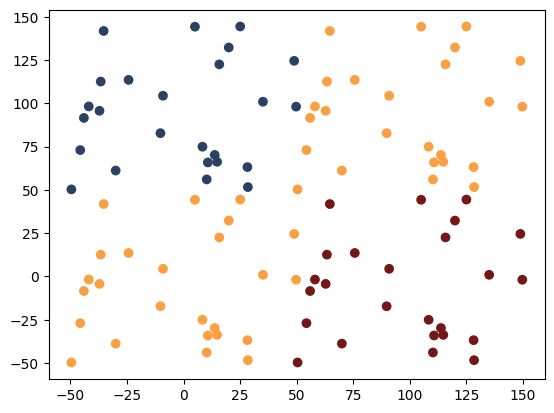

 Inner Node ( feature 1 < 50.079150862376466 )
   Inner Node ( feature 2 < 47.37434158876444 )
     Leaf Node #fa9f42 1.0
     Leaf Node #2b4162 1.0
   Inner Node ( feature 2 < 47.37434158876444 )
     Leaf Node #721817 1.0
     Leaf Node #fa9f42 1.0
('#2b4162', 1.0)


In [20]:
import random

colors = ["#eaeaf2", "#721817", "#2b4162", "#fa9f42"]
feature_names = ["feature 1", "feature 2"]


data_points = []
for i in range(25):
    noiseA = random.uniform(-50, 50)
    noiseB = random.uniform(-50, 50)
    data_points.append( ( [  0+noiseA,   0+noiseB], colors[3]) )
    data_points.append( ( [100+noiseA,   0+noiseB], colors[1]) )
    data_points.append( ( [  0+noiseA, 100+noiseB], colors[2]) )
    data_points.append( ( [100+noiseA, 100+noiseB], colors[3]) )

import matplotlib.pyplot as plt 

X = [a[0][0] for a in data_points]
Y = [a[0][1] for a in data_points]
D = [a[1] for a in data_points]
print( len(X), X[0] )
print( len(Y), Y[0]  )
plt.scatter(X, Y, c=D)
plt.savefig("dataset_synthetic.png", dpi=300, bbox_inches='tight')
plt.show()

tree = build_tree(data_points)
tree.print()

x = [ 25.0, 125.0 ]
prediction = tree.predict( x )
print(prediction)

In [21]:
import csv

class FileFormatException(Exception):
    def __init__(self, line_number):
        super().__init__()
        self.line_number = line_number
        
def load_csv_in_sklearn_format( input_file_name, output_feature ):
    with open(input_file_name, 'r') as file:
        reader = csv.reader(file, delimiter=";")
        X = []
        Y = []
        for line_number,row in enumerate(reader):
            if line_number==0:
                n_features = len( row )
                input_features = []
                for i in range(n_features):
                    if i != output_feature:
                        input_features.append(i)               
            if len(row) != n_features:
                raise FileFormatException(line_number)
            try:
                features = []
                for i in input_features:
                    features.append(float(row[i]))
                X.append( features )
                Y.append( row[output_feature] )
            except Exception: 
                raise FileFormatException(line_number)
    return X, Y

In [22]:
import unittest

class TestNotebook(unittest.TestCase):

    def test_load_correct_file(self):
        x,y = load_csv_in_sklearn_format("iris_data.csv", output_feature=4)
        self.assertTrue(type(x) is list)
        self.assertEqual(len(x), 150)        
        self.assertTrue(type(x[0]) is list)
        self.assertEqual(len(x[0]), 4)        
        self.assertTrue(type(y) is list)
        self.assertEqual(len(y), 150)

    def test_load_corrupt_file(self):
        with self.assertRaises(FileFormatException) as cm:
            x,y = load_csv_in_sklearn_format("corrupt_dataset.csv", output_feature=4)

    def test_gini_index(self):
        test_data_all_same = [ ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 1], "A" ) ]
        test_data_all_different = [ ( [1, 1], "A" ), ( [1, 1], "B" ), ( [1, 1], "C" ), ( [1, 1], "D" ) ]
        test_data_mixed = [ ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 1], "B" ), ( [1, 1], "B" ) ]

        gini_index_all_same = gini_index( test_data_all_same )
        gini_index_all_different = gini_index( test_data_all_different )
        gini_index_mixed = gini_index( test_data_mixed )
        
        self.assertAlmostEqual( gini_index_all_same, 0.0 )
        self.assertAlmostEqual( gini_index_all_different, 0.75 )
        self.assertAlmostEqual( gini_index_mixed, 0.5 )

    def test_select_best_split(self):
        test_data = [ ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 3], "B" ), ( [1, 3], "B" ) ]
        feature, split_value = select_best_split( test_data )
        self.assertEqual( feature, 1 )
        self.assertAlmostEqual( split_value, 2 )

    def test_build_tree(self):
        test_data_recursive_case = [ ( [1, 1], "A" ), ( [21, 1], "A" ), ( [1, 3], "B" ), ( [1, 3], "B" ),( [1, 7], "B" ),( [1, 7], "B" ) ]
        test_data_base_case_all_one_class = [ ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 1], "A" ), ( [3, 3], "A" ), ( [3, 3], "A" ) ]
        test_data_base_case_too_few_data_points = [ ( [1, 1], "A" ), ( [1, 1], "A" ) ]
        test_data_base_case_all_same_features = [ ( [1, 1], "A" ), ( [1, 1], "A" ), ( [1, 1], "B" ), ( [1, 1], "B" ), ( [1, 1], "B" ), ( [1, 1], "B" ) ]

        tree = build_tree( test_data_recursive_case )
        tree2 = build_tree( test_data_base_case_all_one_class )
        tree3 = build_tree( test_data_base_case_too_few_data_points )
        tree4 = build_tree( test_data_base_case_all_same_features )

        self.assertTrue( type(tree) is InnerNode )
        self.assertTrue( type(tree.left_child) is LeafNode )
        self.assertTrue( type(tree.right_child) is LeafNode )
        self.assertTrue( type(tree2) is LeafNode )
        self.assertTrue( type(tree3) is LeafNode )
        self.assertTrue( type(tree4) is LeafNode )

unittest.main(argv=[''], verbosity=2, exit=False)

test_build_tree (__main__.TestNotebook) ... ok
test_gini_index (__main__.TestNotebook) ... ok
test_load_correct_file (__main__.TestNotebook) ... ok
test_load_corrupt_file (__main__.TestNotebook) ... ok
test_select_best_split (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.018s

OK


In [23]:
X, Y = load_csv_in_sklearn_format("iris_data.csv", output_feature=4)
feature_names = ["Kelchblattlänge", "Kelchblattdicke", "Blütenblattlänge", "Blütenblattdicke"]
data_points = list ( zip( X, Y ) )

tree = build_tree( data_points)
tree.print()

 Inner Node ( Blütenblattlänge < 3.758666666666666 )
   Inner Node ( Kelchblattdicke < 3.4 )
     Inner Node ( Blütenblattlänge < 1.8444444444444446 )
       Leaf Node Iris-setosa 1.0
       Inner Node ( Blütenblattdicke < 0.95 )
         Leaf Node Iris-setosa 1.0
         Leaf Node Iris-versicolor 1.0
     Leaf Node Iris-setosa 1.0
   Inner Node ( Blütenblattdicke < 1.7 )
     Inner Node ( Blütenblattdicke < 1.3787234042553191 )
       Leaf Node Iris-versicolor 1.0
       Inner Node ( Kelchblattdicke < 3.0 )
         Inner Node ( Blütenblattlänge < 4.747368421052631 )
           Inner Node ( Blütenblattdicke < 1.5 )
             Leaf Node Iris-versicolor 1.0
             Leaf Node Iris-virginica 1.0
           Inner Node ( Blütenblattlänge < 5.1625 )
             Inner Node ( Kelchblattlänge < 6.3 )
               Leaf Node Iris-virginica 0.5
               Leaf Node Iris-versicolor 1.0
             Leaf Node Iris-virginica 1.0
         Leaf Node Iris-versicolor 1.0
     Inner Node ( 